In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import patches as mpatches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy


import metpy.calc as mpcalc
from metpy.units import units

import warnings

import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat

# Preprocessing

## Functions

In [2]:
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"


boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Colombia/Venezuela",
           "South Asia",
           "Vietnam",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "Brazil"
          ]
plots_order=[0,1,2,3,7,6,5,4]

In [3]:
#Data extraction from ERA5
era5yrs = list(range(1998,2014))

def era5_file(year,varid):
    """return file path to an ERA5 variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    try :
        fpath = glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    except IndexError :
        path = "/global/cscratch1/sd/qnicolas/era5monthly/"
        fpath = glob.glob(os.path.join(path,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    return fpath


#def climatology_era5(varid):
#    paths = [era5_file(year,varid) for year in era5yrs]
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore",FutureWarning)
#        ds = xr.open_mfdataset(paths).chunk({'latitude':30,'longitude':30,'time':1000}).groupby("time.month").mean("time").compute()
#        varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
#        return ds[varname]
    
def climatology_era5(varid):
    paths = [era5_file(year,varid) for year in era5yrs]
    temp=0
    for p in paths:
        #print(p)
        ds = xr.open_dataset(p)
        ds.coords['month'] = ds['time.month']
        ds = ds.swap_dims({'time': 'month'}).drop('time')
        temp+=ds
    varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
    return temp[varname]/len(paths)


def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean

def region_mean2D_trmm(variable,mask,box):
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean


In [4]:
def p_k_half_era5(ps):
    """Given a surface pressure in Pa,
    return the pressure level p_{k+1/2} from which to compute the surface part 
    of the integral (see SeagerHenderson2013 - eq (22))
    args :
     - ps (float) : surface pressure in Pa
     
     Namely, finds the pressure levels p_k and p_{k+1} such that pk <= ps < p_{k+1}
     and returns (p_k + p_{k+1})/2; if ps >= 1e5 Pa = 1000 hPa, returns 1e5 Pa
    """
    plevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
    
    return (plevs[np.searchsorted(plevs,ps)-1]+
            plevs[np.minimum(np.searchsorted(plevs,ps),len(plevs)-1)])/2

def ddx(F):
    """return zonal derivative in spherical coordinates"""
    coslat = np.cos(F.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180
    return F.differentiate("longitude")/(m_per_degreelat*coslat)

def ddy(F):
    """return meridional derivative in spherical coordinates"""
    coslat = np.cos(F.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180
    return F.differentiate("latitude")/m_per_degreelat

def divergence(Fx,Fy):
    """return divergence in spherical coordinates"""
    coslat = np.cos(Fx.latitude*np.pi/180.)
    coslat += 1e-5*(1-1*(coslat>1e-5))
    m_per_degreelat = 6370*1e3*np.pi/180    
    return (Fx.differentiate("longitude") + (Fy*coslat).differentiate("latitude"))/(m_per_degreelat*coslat)

def compute_mc_terms(q,u,v,w,ps):
    uq = u*q  
    uq_vinteg = ((uq*(100*uq.level<ps)).integrate("level")*100 +
                 (uq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    
    vq = v*q  
    vq_vinteg = ((vq*(100*vq.level<ps)).integrate("level")*100 +
                 (vq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = vq_k * (p_s - p_{k+1/2})
                )
    
    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    
    #minimum surface pressure of the neighboring elements of each grid cell
    psa = np.array(ps )
    psa_n = np.amin(np.array([psa,np.roll(psa,(1,0)),np.roll(psa,(-1,0)),np.roll(psa,(0,1)),np.roll(psa,(0,-1))]),axis=0) 
    ps_n = xr.DataArray(psa_n,ps.coords)
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w*(100*ddp_w.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    #conv_term 2 = -(q  *divergence(u  ,v  )*(100*q.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #Minus moisture advection = -<u.grad(q)>
    adv_term  = -((u*ddx(q)+v*ddy(q))*(100*u.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #surface contribution
    sfc_term = mc -conv_term-adv_term
    return mc ,conv_term,adv_term,sfc_term

def compute_mc(q,u,v,ps):
    uq = u*q  
    uq_vinteg = ((uq*(100*uq.level<ps)).integrate("level")*100 +
                 (uq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    
    vq = v*q  
    vq_vinteg = ((vq*(100*vq.level<ps)).integrate("level")*100 +
                 (vq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = vq_k * (p_s - p_{k+1/2})
                )
    
    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    return mc

## Masks, data

In [5]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

#masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)

REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.pl/e5.moda.an.pl.128_060_pv.ll025sc.1979010100_1979120100.nc").PV.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.   
trmm_nh_winter_mask = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask = slide_coord(trmm_sh_winter_mask)

In [6]:
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=(landmask.interp_like(REFERENCE_GRID) > 0)*1.


In [7]:
all_pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
all_pr_trmm=all_pr_trmm.groupby("time.month").mean("time")


In [8]:
u_seasmean = xr.open_dataset('e5.moda.an.pl.128_131_u.ll025sc.1998010100_2013123123.seasonalmean.nc').U
v_seasmean = xr.open_dataset('e5.moda.an.pl.128_132_v.ll025sc.1998010100_2013123123.seasonalmean.nc').V
w_seasmean = xr.open_dataset('e5.moda.an.pl.128_135_w.ll025sc.1998010100_2013123123.seasonalmean.nc').W
q_seasmean = xr.open_dataset('e5.moda.an.pl.128_133_q.ll025sc.1998010100_2013123123.seasonalmean.nc').Q
ps_seasmean = climatology_era5('128_134_sp')

In [9]:
t=time.time()
mc_seasmean,conv_seasmean,adv_seasmean,sfc_seasmean = compute_mc_terms(q_seasmean ,u_seasmean,v_seasmean,w_seasmean,ps_seasmean)
print(time.time()-t)

151.7667202949524


In [10]:
mc_e5_seasmean = - climatology_era5('128_213_vimd')
pr_e5_seasmean = 1000*climatology_era5('128_228_tp')
e_seasmean = -1000*climatology_era5('128_182_e')

# ERA5 (1998-2013 years only) vs TRMM (1998-2013) seasonal precip 

The plot below shows :
 - In dark green, TRMM seasonal mean precipitation
 - In light green, ERA5 seasonal mean precipitation over the TRMM era (1998-2013)
 - In dark blue, ERA5 seasonal mean VIMC (1998-2013)
 - In light blue, mean VIMC is approximated by VIMC of the seasonal mean state (light blue line $\simeq$ dark blue line); the difference being the transient terms

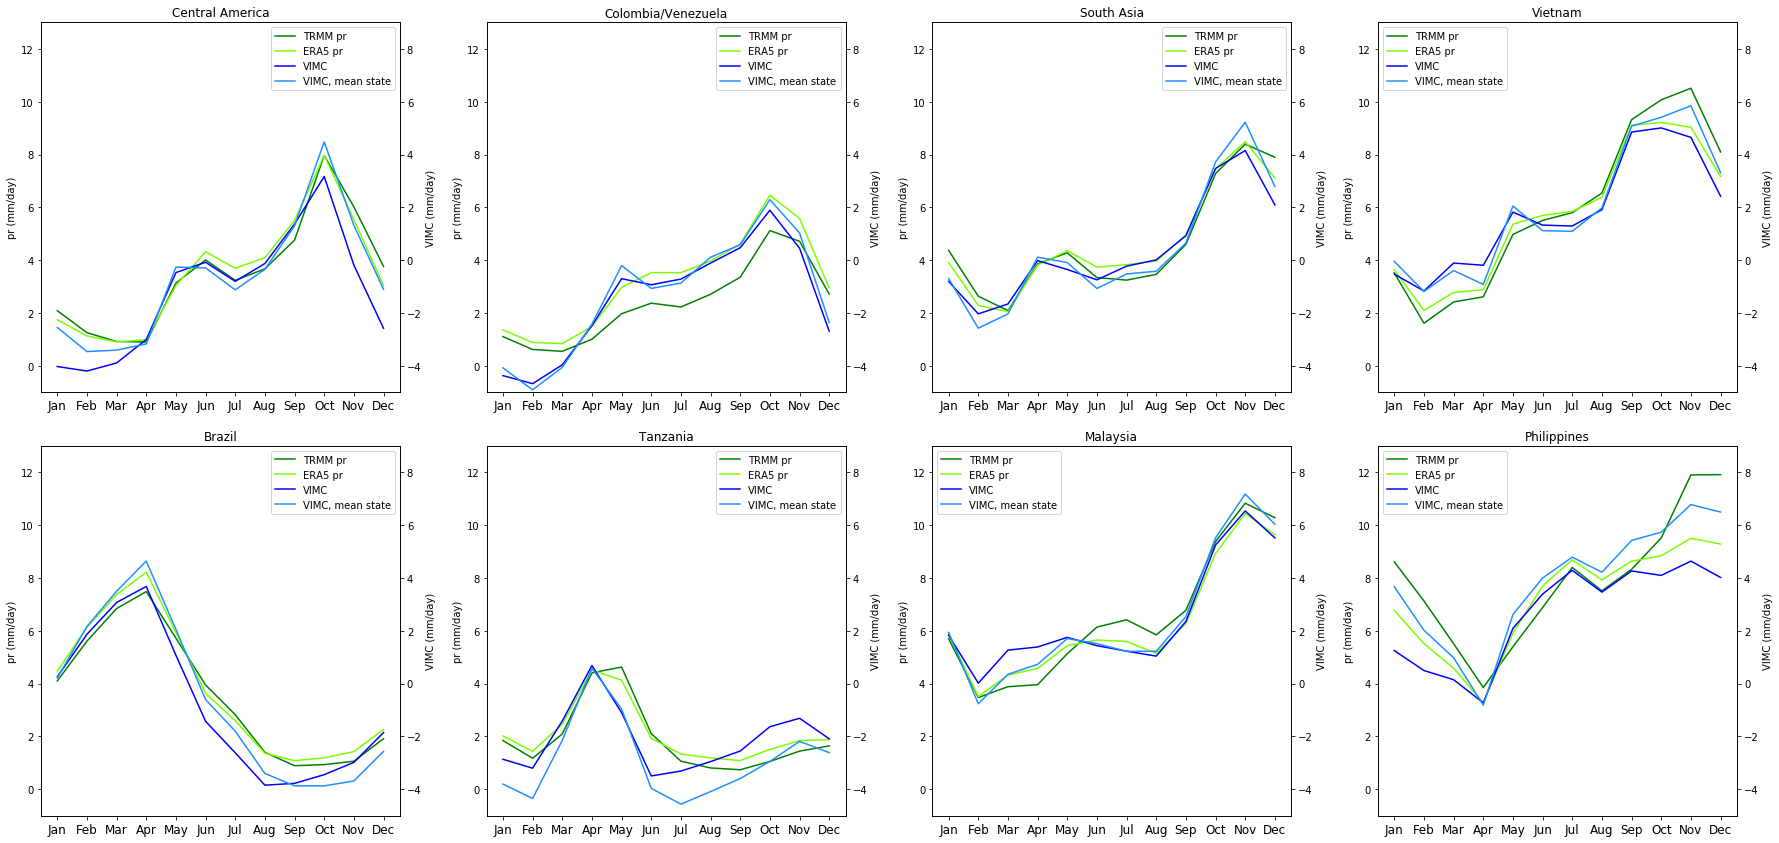

In [11]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)[plots_order]

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask
    
    ax[i].plot(mnths,region_mean2D_trmm(all_pr_trmm,mask2,box),color='green',label="TRMM pr")
    ax[i].plot(mnths,region_mean2D(pr_e5_seasmean,mask,box),color='lawngreen',label="ERA5 pr")
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(-1,13);ax[i].set_ylabel('pr (mm/day)')
    #ax[i].plot([4,4],[0,pr_era5[4]],':g'   )
    #ax[i].plot([10,10],[0,pr_trmm[10]],':g')
    ax[i].plot([0.],[0.],color='blue',label="VIMC")# for the legend
    ax[i].plot([0.],[0.],color='dodgerblue',label="VIMC, mean state")
    ax[i].legend()
    
    ax2=ax[i].twinx()
    ax2.plot(mnths,region_mean2D(mc_e5_seasmean,mask,box),color='blue',label="VIMC")
    ax2.plot(mnths,region_mean2D(mc_seasmean,mask,box),color='dodgerblue',label="VIMC, mean state")
    ax2.set_ylim(-5,9);ax2.set_ylabel('VIMC (mm/day)')


matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()

In [12]:
masks=[trmm_nh_winter_mask1]*6+[trmm_sh_winter_mask1]*2
peak_months_era5=[1+int(region_mean2D(pr_e5_seasmean,masks[i],box).argmax('month')) for i,box in enumerate(boxNH1+boxSH1)] #month of peak rainfall in ERA5


# Seasonal variation of the moisture budget terms

Explanation of the below graphs :
 - Precip = Vertically integrated moisture convergence (VIMC) + evaporation (dark blue line + red line)
 - The VIMC of the mean state is decomposed as a sum of 3 terms :  (convergence term) + (minus moisture advection) + (surface term), ie $$-\mathbf{ \nabla} \cdot \displaystyle\int_0^{p_s}  (q\mathbf {u})\;dp/g = -\displaystyle\int_0^{p_s} q \mathbf{ \nabla} \cdot \mathbf {u}\;dp/g -\displaystyle\int_0^{p_s} \mathbf {u} \cdot \mathbf{ \nabla} q \;dp/g - (q_s\mathbf{ u_s} \cdot \nabla p_s)/g$$
 - For all the regions but Viet-Nam and the Philippines, seasonal variations of precipitation are explained at first order by seasonal variations of the convergence term $-\displaystyle\int_0^{p_s} q \mathbf{ \nabla} \cdot \mathbf {u}\;dp/g$

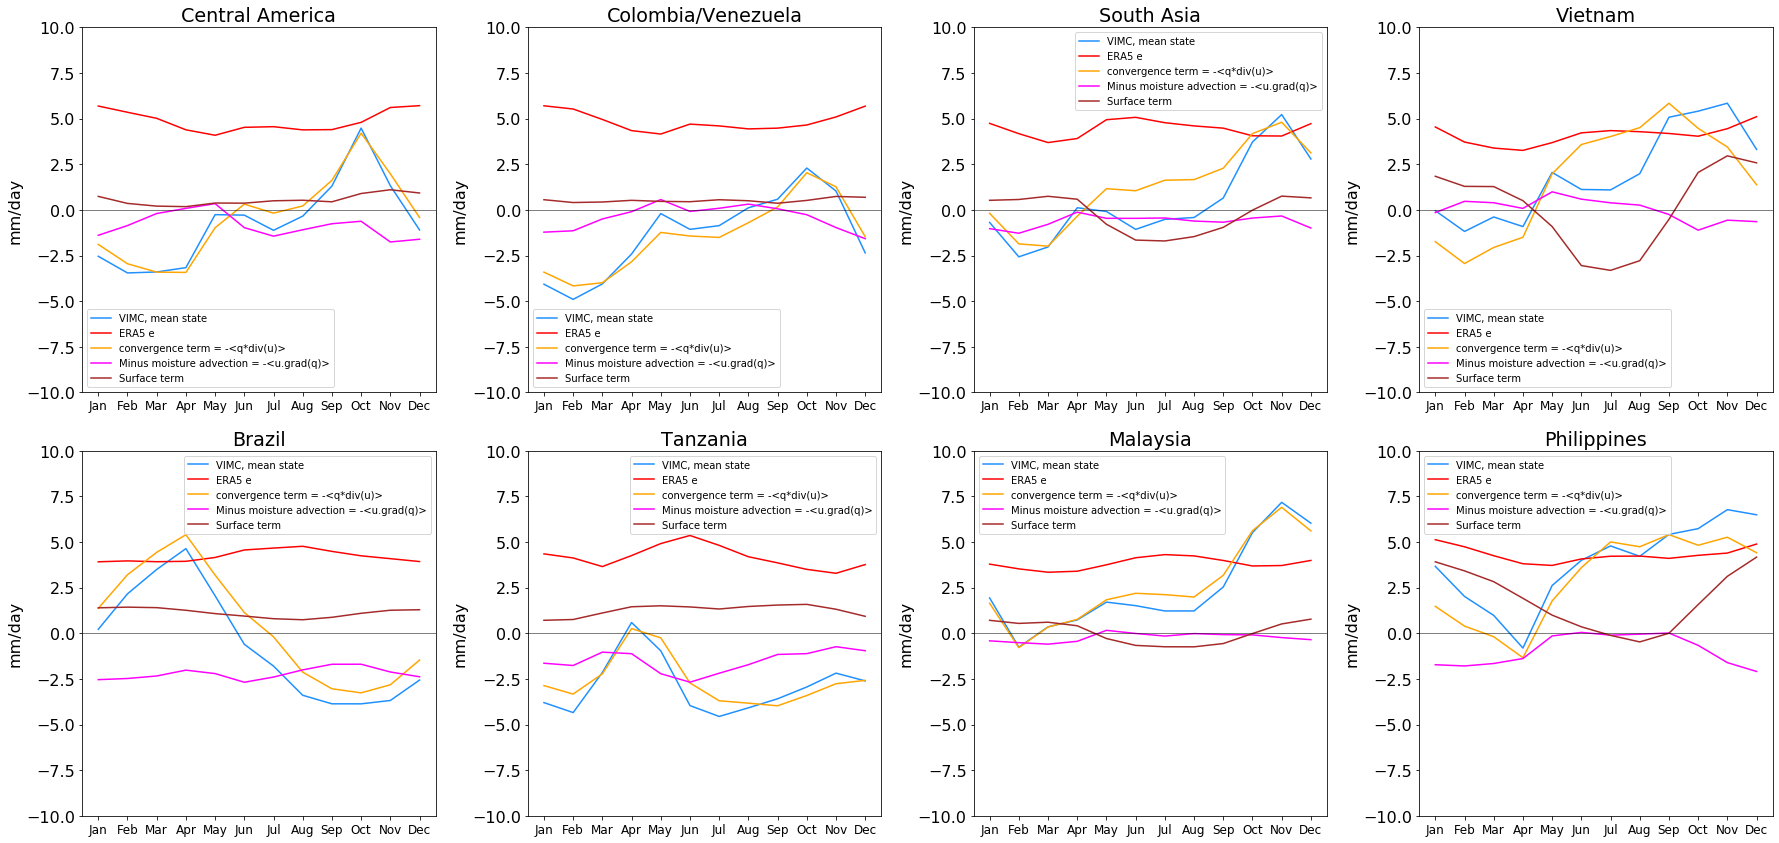

In [13]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)[plots_order]

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask

    #ax[i].plot(mnths,region_mean2D(mc_e5_seasmean,mask,box),color='blue',label="VIMC")
    ax[i].plot(mnths,region_mean2D(mc_seasmean,mask,box),color='dodgerblue',label="VIMC, mean state")
    ax[i].plot(mnths,region_mean2D(e_seasmean,mask,box),color='red',label="ERA5 e")
    ax[i].plot(mnths,region_mean2D(conv_seasmean,mask,box),color='orange',label="convergence term = -<q*div(u)>")
    ax[i].plot(mnths,region_mean2D(adv_seasmean,mask,box),color='magenta',label="Minus moisture advection = -<u.grad(q)>")
    ax[i].plot(mnths,region_mean2D(sfc_seasmean,mask,box),color='brown',label="Surface term")
                    
        
        
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(-10,10);ax[i].set_ylabel('mm/day')
    #ax[i].plot([4,4],[-10,10],':k')
    #ax[i].plot([10,10],[-10,10],':k')
    ax[i].legend(prop={'size': 10})
    ax[i].axhline(0,color='k',linewidth='0.5')


matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()

# A second approach to the seasonal variation of the VIMC

Here I decompose the seasonally-varying part of the VIMC as : $$ - \nabla \langle q \mathbf {u} \rangle - (- \nabla \langle \bar{q} \bar{\mathbf{u}} \rangle)= - \nabla \langle \bar{q} \mathbf {u}' \rangle - \nabla \langle q' \bar{\mathbf{u}} \rangle - \nabla \langle  q' \mathbf {u}' \rangle $$

where an overbar denotes an annual mean, and a prime the remaining seasonal variation. Also $\langle \cdot\rangle = \displaystyle\int_0^{p_s} \cdot \;dp/g$

To first order, the variations are explained by changes in the wind.


In [14]:
q_anmean = q_seasmean.mean("month")
u_anmean = u_seasmean.mean("month")
v_anmean = v_seasmean.mean("month")
ps_anmean = ps_seasmean.mean("month")

In [15]:
#all are calculated with annual-mean surface pressure so that the budget closes well
mc_e5_seasmean = compute_mc(q_seasmean,u_seasmean,v_seasmean,ps_anmean)
mc_e5_anmean = compute_mc(q_anmean,u_anmean,v_anmean,ps_anmean)
qbup = compute_mc(q_anmean,u_seasmean - u_anmean,v_seasmean - v_anmean,ps_anmean)
qpub = compute_mc(q_seasmean - q_anmean,u_anmean,v_anmean,ps_anmean)
qpup = compute_mc(q_seasmean - q_anmean,u_seasmean - u_anmean,v_seasmean - v_anmean,ps_anmean)

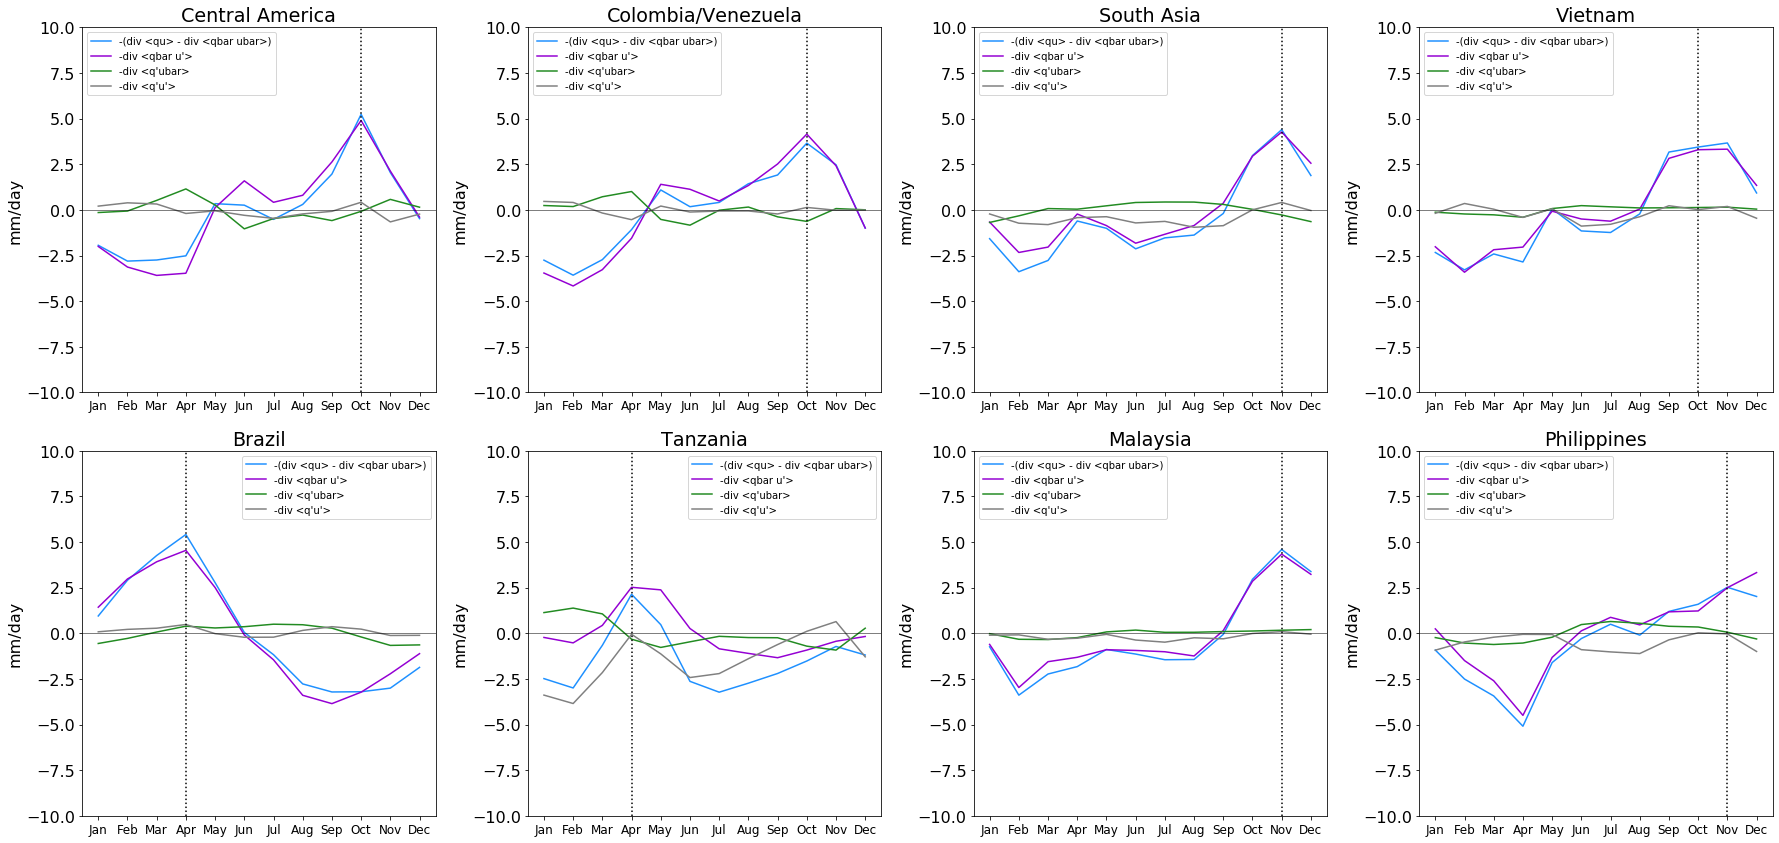

In [16]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)[plots_order]

mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        mask2 = trmm_nh_winter_mask
    else :
        mask = trmm_sh_winter_mask1
        mask2 = trmm_sh_winter_mask

    ax[i].plot(mnths,region_mean2D(mc_e5_seasmean-mc_e5_anmean,mask,box),color='dodgerblue',label="-(div <qu> - div <qbar ubar>)")
    ax[i].plot(mnths,region_mean2D(qbup,mask,box),color='darkviolet',label="-div <qbar u'>")
    ax[i].plot(mnths,region_mean2D(qpub,mask,box),color='forestgreen',label="-div <q'ubar>")
    ax[i].plot(mnths,region_mean2D(qpup,mask,box),color='gray',label="-div <q'u'>")
                       
    ax[i].set_title((namesNH+namesSH)[i])
    ax[i].set_ylim(-10,10);ax[i].set_ylabel('mm/day')
    ax[i].plot([peak_months_era5[i]-1,peak_months_era5[i]-1],[-10,10],':k')
    ax[i].legend(prop={'size': 10})
    ax[i].axhline(0,color='k',linewidth='0.5')


matplotlib.rcParams.update({'font.size': 16})
for a in ax : a.tick_params(axis = 'x', which = 'major', labelsize = 12)
fig.tight_layout()

In [17]:
from tabulate import tabulate

print(' '*10+'\033[1m'+ "Values of the different terms over peak rainfall month (indicated by dotted line above)" + '\033[0m \n')

tab=[]
for i,box in enumerate(boxNH1+boxSH1):
    tab.append([(namesNH+namesSH)[i] +' (' + mnths[peak_months_era5[i]-1]+')', 
                "%.2f"%region_mean2D(mc_e5_seasmean-mc_e5_anmean,masks[i],box).sel(month=peak_months_era5[i]),
                "%.2f"%region_mean2D(qbup,masks[i],box).sel(month=peak_months_era5[i]),
                "%.2f"%region_mean2D(qpub,masks[i],box).sel(month=peak_months_era5[i]),
                "%.2f"%region_mean2D(qpup,masks[i],box).sel(month=peak_months_era5[i]),
               ])
tab=np.array(tab)[plots_order]
print(tabulate(tab, headers=['Region'+' '*17, "-(div <qu> - div <qbar ubar>)","-div <qbar u'>","-div <q'ubar>","-div <q'u'>"]))

    

          Values of the different terms over peak rainfall month (indicated by dotted line above) 

Region                       -(div <qu> - div <qbar ubar>)    -div <qbar u'>    -div <q'ubar>    -div <q'u'>
-------------------------  -------------------------------  ----------------  ---------------  -------------
Central America (Oct)                                 5.24              4.9             -0.08           0.42
Colombia/Venezuela (Oct)                              3.66              4.15            -0.63           0.14
South Asia (Nov)                                      4.4               4.27            -0.28           0.41
Vietnam (Oct)                                         3.44              3.3              0.13           0.02
Brazil (Apr)                                          5.41              4.54             0.39           0.48
Tanzania (Apr)                                        2.14              2.52            -0.33          -0.06
Malaysia (Nov)              